In [1]:
import sys
from pathlib import Path
sys.path.insert(0,str(Path.cwd().parent))
from package import *
from datetime import datetime
from package.DandjooId import DandjooId
from shapely.geometry import MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import socket
from dateutil import parser
from datetime import datetime
from pyproj import Proj, transform
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth',None)

QUALITY ASSURANCE CHECK ON CRPTOGAMS MASTER DATA

Step 1) User specifies path to file in blob store container, file read as dataframe.

In [2]:
# Define containers: 010-recieved, 015-recieved, record deltas
creds: pd.DataFrame = pd.read_csv('credential.csv',dtype=str, index_col='item')
cred: str = creds.loc['cred','value']

a10_recieved: str = creds.loc['10_recieved','value']
a15_extracted: str = creds.loc['15_extracted','value']
a20_tabular: str = creds.loc['20_tabular','value']
a25_preprocessed: str = creds.loc['25_preprocessed','value']
a30_ingestion: str = creds.loc['30_ingestion','value']

a10_recieved: ContainerClient = ContainerClient.from_container_url(a10_recieved, cred)
a15_extracted: ContainerClient = ContainerClient.from_container_url(a15_extracted, cred)
a20_tabular: ContainerClient = ContainerClient.from_container_url(a20_tabular, cred)
a25_preprocessed: ContainerClient = ContainerClient.from_container_url(a25_preprocessed, cred)
a30_ingestion: ContainerClient = ContainerClient.from_container_url(a30_ingestion, cred)

# Define file paramaters - the path of the file in the blobstore.
infile: Path = Path('AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx')
parent: Path = infile.parent
filename: str = infile.name.removesuffix(infile.suffix).lower().replace('.','')
filename = '_'.join(filename.split())
targetp: Path = parent / f'{filename}.csv'
partdir: Path = parent / filename
logpath: Path = partdir / f'{filename}_log.csv'
invpath: Path = partdir / f'{filename}_invalid.csv'

eventlog: pd.DataFrame = pd.DataFrame(columns=['event_id','datetime','user','description'])
message, af = read_df(a15_extracted, infile)
af.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,DATE,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,DAY,MONTH,YEAR,OBSERVERS,SPECIES #,ORDER,FAMILY,TAXON,LIFE TYPE,LIFE STYLE,MICRO HABITAT,MACRO STRATAL POSITION,MICRO HABITAT FREQUENCY,SITE FREQUENCY,SECTION,PLOT NO,GRID PREFIX,LOCATION,TREATEMENT,FIRE TREATMENT,GDA94 EASTING Central Peg W2.3,GDA94 NORTHING Central Peg W2.3,SECTION Easting,SECTION Northing,Notes
1,12948,SV9-329,329,2010,SPRING,1,11,2010,Ray CRANFIELD and Lisa LUTZ,363,Acarsporales,Acarosporaceae,Acarospora citrina,Lichen,Crustose,Wood & Bark,NaN,NaN,NaN,50-100,FC31,WGF4,GODFREY,GAP RELEASE,NaN,447000.35847,6317400.68881,447043.3901125,6317364.89034,NaN
2,10420,SV4-101,101,2004,SPRING,5,10,2004,Ray CRANFIELD and one other,248,Acarsporales,Acarosporaceae,Acarospora sp. brown (R.J. Cranfield 20633),Lichen,Crustose,Termite mound,0 cm to 30 cm,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC30,WGF3,GODFREY,SHELTERWOOD,NaN,446321.43577,6318929.19595,NaN,NaN,NaN
3,9814,SV2-69,69,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Frequent (50 to 70 %),Occasional (5 to 14 %),NaN,FC12,HRS4,ROSS,GAP RELEASE,NaN,428238.8,6335023.38003,NaN,NaN,NaN
4,9852,SV2-107,107,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,0 cm to 30 cm AND 31 cm to 3.0 m,Occasional (10 to 49 %),Occasional (5 to 14 %),NaN,FC13,HRS3,ROSS,SHELTERWOOD,NaN,428792.94,6334612.11003,NaN,NaN,NaN


Logged error while reading file

In [3]:
logevent(description=f'errors when reading file "{str(infile)}" : {message}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JZIBF47f7895,2024-09-25T08:01:05.294792,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" : N/A"


Set the first row (row's numbering 0) in 'af' DataFrame,  as the new header

In [4]:
aff: pd.DataFrame = af.copy(deep=True)  # Make a copy of the original DataFrame (af) so that changes to aff doesn't affect af

aff.columns = aff.iloc[0]  # Set the first row's as the new header

# Drop the first row, since it's now the header. I.e, since the row 0's from the af dataframe has become the new header, use the next row (ie row 1 in af) as the first row in aff dataframe
aff = aff[1:]

# Reset the index to ensure a clean DataFrame
aff.reset_index(drop=True, inplace=True)

# Display the final DataFrame
aff.head()

# Optional, get the new column names
#aff.columns

,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,DAY,MONTH,YEAR,OBSERVERS,SPECIES #,ORDER,FAMILY,TAXON,LIFE TYPE,LIFE STYLE,MICRO HABITAT,MACRO STRATAL POSITION,MICRO HABITAT FREQUENCY,SITE FREQUENCY,SECTION,PLOT NO,GRID PREFIX,LOCATION,TREATEMENT,FIRE TREATMENT,GDA94 EASTING Central Peg W2.3,GDA94 NORTHING Central Peg W2.3,SECTION Easting,SECTION Northing,Notes
0,12948,SV9-329,329,2010,SPRING,1,11,2010,Ray CRANFIELD and Lisa LUTZ,363,Acarsporales,Acarosporaceae,Acarospora citrina,Lichen,Crustose,Wood & Bark,NaN,NaN,NaN,50-100,FC31,WGF4,GODFREY,GAP RELEASE,NaN,447000.35847,6317400.68881,447043.3901125,6317364.89034,NaN
1,10420,SV4-101,101,2004,SPRING,5,10,2004,Ray CRANFIELD and one other,248,Acarsporales,Acarosporaceae,Acarospora sp. brown (R.J. Cranfield 20633),Lichen,Crustose,Termite mound,0 cm to 30 cm,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC30,WGF3,GODFREY,SHELTERWOOD,NaN,446321.43577,6318929.19595,NaN,NaN,NaN
2,9814,SV2-69,69,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Frequent (50 to 70 %),Occasional (5 to 14 %),NaN,FC12,HRS4,ROSS,GAP RELEASE,NaN,428238.8,6335023.38003,NaN,NaN,NaN
3,9852,SV2-107,107,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,0 cm to 30 cm AND 31 cm to 3.0 m,Occasional (10 to 49 %),Occasional (5 to 14 %),NaN,FC13,HRS3,ROSS,SHELTERWOOD,NaN,428792.94,6334612.11003,NaN,NaN,NaN
4,9946,SV2-205,205,2003,AUTUMN,22,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC16,HYD1,YOURDAMUNG,EXTERNAL CONTROL,NaN,427620.46,6323349.22003,NaN,NaN,NaN


Renaming some complex column names into a simple name

In [5]:
def rename_columns(df, columns_dict):
    """
    Rename columns in a Dataframe.

    Parameters:
    df(pd.DataFrame): The DataFrame whose columns need to be renamed.
    columns_dict(dict): A dictionary where keys are old column names and values are new column names.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    df.rename(columns=columns_dict, inplace=True)
    return df

# Renaming columns
new_columns = {'TAXON':'TAXON NAME', 'GDA94 EASTING Central Peg W2.3': 'GDA94 EASTING Central', 'GDA94 NORTHING Central Peg W2.3': 'GDA94 NORTHING Central', 'SPECIES #': 'SPECIES'}
aff = rename_columns(aff, new_columns)
aff.head()

,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,DAY,MONTH,YEAR,OBSERVERS,SPECIES,ORDER,FAMILY,TAXON NAME,LIFE TYPE,LIFE STYLE,MICRO HABITAT,MACRO STRATAL POSITION,MICRO HABITAT FREQUENCY,SITE FREQUENCY,SECTION,PLOT NO,GRID PREFIX,LOCATION,TREATEMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,SECTION Easting,SECTION Northing,Notes
0,12948,SV9-329,329,2010,SPRING,1,11,2010,Ray CRANFIELD and Lisa LUTZ,363,Acarsporales,Acarosporaceae,Acarospora citrina,Lichen,Crustose,Wood & Bark,NaN,NaN,NaN,50-100,FC31,WGF4,GODFREY,GAP RELEASE,NaN,447000.35847,6317400.68881,447043.3901125,6317364.89034,NaN
1,10420,SV4-101,101,2004,SPRING,5,10,2004,Ray CRANFIELD and one other,248,Acarsporales,Acarosporaceae,Acarospora sp. brown (R.J. Cranfield 20633),Lichen,Crustose,Termite mound,0 cm to 30 cm,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC30,WGF3,GODFREY,SHELTERWOOD,NaN,446321.43577,6318929.19595,NaN,NaN,NaN
2,9814,SV2-69,69,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Frequent (50 to 70 %),Occasional (5 to 14 %),NaN,FC12,HRS4,ROSS,GAP RELEASE,NaN,428238.8,6335023.38003,NaN,NaN,NaN
3,9852,SV2-107,107,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,0 cm to 30 cm AND 31 cm to 3.0 m,Occasional (10 to 49 %),Occasional (5 to 14 %),NaN,FC13,HRS3,ROSS,SHELTERWOOD,NaN,428792.94,6334612.11003,NaN,NaN,NaN
4,9946,SV2-205,205,2003,AUTUMN,22,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC16,HYD1,YOURDAMUNG,EXTERNAL CONTROL,NaN,427620.46,6323349.22003,NaN,NaN,NaN


Convert the location data ('GDA94 EASTING Central' and 'GDA94 NORTHING Central') to Longitude and Latitude

In [6]:
# Define projections using EPSG codes
gda94 = Proj('epsg:28350')  # GDA94 
wgs84 = Proj('epsg:4326')   # WGS84

# Function to convert coordinates
def convert_to_latlon(easting, northing):
    lat, lon = transform(gda94, wgs84, easting, northing)
    return lat, lon

# Apply conversion by calling the function
aff['Latitude'], aff['Longitude'] = zip(*aff.apply(lambda row: convert_to_latlon(row['GDA94 EASTING Central'], row['GDA94 NORTHING Central']), axis=1))

aff.head()

/tmp/ipykernel_933/1575176851.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat, lon = transform(gda94, wgs84, easting, northing)


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,DAY,MONTH,YEAR,OBSERVERS,SPECIES,ORDER,FAMILY,TAXON NAME,LIFE TYPE,LIFE STYLE,MICRO HABITAT,MACRO STRATAL POSITION,MICRO HABITAT FREQUENCY,SITE FREQUENCY,SECTION,PLOT NO,GRID PREFIX,LOCATION,TREATEMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,SECTION Easting,SECTION Northing,Notes,Latitude,Longitude
0,12948,SV9-329,329,2010,SPRING,1,11,2010,Ray CRANFIELD and Lisa LUTZ,363,Acarsporales,Acarosporaceae,Acarospora citrina,Lichen,Crustose,Wood & Bark,NaN,NaN,NaN,50-100,FC31,WGF4,GODFREY,GAP RELEASE,NaN,447000.35847,6317400.68881,447043.3901125,6317364.89034,NaN,-33.281140,116.430840
1,10420,SV4-101,101,2004,SPRING,5,10,2004,Ray CRANFIELD and one other,248,Acarsporales,Acarosporaceae,Acarospora sp. brown (R.J. Cranfield 20633),Lichen,Crustose,Termite mound,0 cm to 30 cm,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC30,WGF3,GODFREY,SHELTERWOOD,NaN,446321.43577,6318929.19595,NaN,NaN,NaN,-33.267320,116.423640
2,9814,SV2-69,69,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Frequent (50 to 70 %),Occasional (5 to 14 %),NaN,FC12,HRS4,ROSS,GAP RELEASE,NaN,428238.8,6335023.38003,NaN,NaN,NaN,-33.121110,116.230766
3,9852,SV2-107,107,2003,AUTUMN,20,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,0 cm to 30 cm AND 31 cm to 3.0 m,Occasional (10 to 49 %),Occasional (5 to 14 %),NaN,FC13,HRS3,ROSS,SHELTERWOOD,NaN,428792.94,6334612.11003,NaN,NaN,NaN,-33.124856,116.236673
4,9946,SV2-205,205,2003,AUTUMN,22,5,2003,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC16,HYD1,YOURDAMUNG,EXTERNAL CONTROL,NaN,427620.46,6323349.22003,NaN,NaN,NaN,-33.226362,116.223210


Concartenate the 'YEAR', 'MONTH' and 'DAY' column in 'aff' DataFrame to a new column called 'DATE'

In [7]:
# Create a new variable for the aff dataframe above
af1: pd.DataFrame = aff.copy(deep=True)

# Ensure column names are correct
af1.columns = af1.columns.str.strip()

# Drop any duplicate column (ie select only columns that are not duplicate(~))
af1 = af1.loc[:, ~af1.columns.duplicated()]

# Create 'DATE' column, and ensure that invalid 'DATES' are converted to NAN (Using the function, errors='coerce')
af1['DATE'] = pd.to_datetime(af1[['YEAR','MONTH','DAY']], errors='coerce')

# Drop rows where 'DATE' is NAN or Not a time
#af1 = af1.dropna(subset=['DATE'])

af1.head()


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,DAY,MONTH,OBSERVERS,SPECIES,ORDER,FAMILY,TAXON NAME,LIFE TYPE,LIFE STYLE,MICRO HABITAT,MACRO STRATAL POSITION,MICRO HABITAT FREQUENCY,SITE FREQUENCY,SECTION,PLOT NO,GRID PREFIX,LOCATION,TREATEMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,SECTION Easting,SECTION Northing,Notes,Latitude,Longitude,DATE
0,12948,SV9-329,329,2010,SPRING,1,11,Ray CRANFIELD and Lisa LUTZ,363,Acarsporales,Acarosporaceae,Acarospora citrina,Lichen,Crustose,Wood & Bark,NaN,NaN,NaN,50-100,FC31,WGF4,GODFREY,GAP RELEASE,NaN,447000.35847,6317400.68881,447043.3901125,6317364.89034,NaN,-33.281140,116.430840,2010-11-01
1,10420,SV4-101,101,2004,SPRING,5,10,Ray CRANFIELD and one other,248,Acarsporales,Acarosporaceae,Acarospora sp. brown (R.J. Cranfield 20633),Lichen,Crustose,Termite mound,0 cm to 30 cm,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC30,WGF3,GODFREY,SHELTERWOOD,NaN,446321.43577,6318929.19595,NaN,NaN,NaN,-33.267320,116.423640,2004-10-05
2,9814,SV2-69,69,2003,AUTUMN,20,5,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Frequent (50 to 70 %),Occasional (5 to 14 %),NaN,FC12,HRS4,ROSS,GAP RELEASE,NaN,428238.8,6335023.38003,NaN,NaN,NaN,-33.121110,116.230766,2003-05-20
3,9852,SV2-107,107,2003,AUTUMN,20,5,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,0 cm to 30 cm AND 31 cm to 3.0 m,Occasional (10 to 49 %),Occasional (5 to 14 %),NaN,FC13,HRS3,ROSS,SHELTERWOOD,NaN,428792.94,6334612.11003,NaN,NaN,NaN,-33.124856,116.236673,2003-05-20
4,9946,SV2-205,205,2003,AUTUMN,22,5,Ray CRANFIELD and one other,144,Teloschistales,Physciaceae,Amandinea punctata,Lichen,Crustose,Wood,31 cm to 3.0 m,Occasional (10 to 49 %),Isolated (1 to 2 %),NaN,FC16,HYD1,YOURDAMUNG,EXTERNAL CONTROL,NaN,427620.46,6323349.22003,NaN,NaN,NaN,-33.226362,116.223210,2003-05-22


Step 2) Tag file with submission_id and dataset (if known).

In [8]:
exist: dict[str,str] = gettags(a15_extracted, infile)
tags: dict[str,str] = {'submission_id': str(DandjooId()), 'dataset': 'Crptogams Master File data'}
tagfile(a15_extracted, infile, tags)

logevent(description=f'"{infile}" in container "015-extracted-data" tagged with: {tags}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JZIBF47f7895,2024-09-25T08:01:05.294792,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" : N/A"
1,2024JZIDF289f78f,2024-09-25T08:03:05.166427,Charles,"""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}"


Step 3) Assign Ids to rows column : 'persistent_id(bio)'  
Step 4) Write complete dataframe to 020-tabular-data

In [9]:
uid_column: str = 'persistent_id(bio)'
bf: pd.DataFrame = af1.copy(deep=True)
uids: pd.Series = pd.Series([str(DandjooId()) for i in range(len(bf))])

if not uids.is_unique:
    raise Exception('uids not unique.')
bf[uid_column] = uids

logevent(description=f'{len(bf)} uids added to column "{uid_column}".',
         user=socket.gethostname(),
         eventlog=eventlog)

ordered: list[str] = [uid_column] + [x for x in bf.columns if x != uid_column]
bf = bf.loc[:, ordered]
write_to_blob(bf, a20_tabular, targetp, index=False, timeout=12000)

# assign submission id to file in twelve extracted.
tagfile(a20_tabular, targetp, tags)
#bf.head()

{'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}

Step 5) Apply submission_id and dataset name to the records.

In [10]:
bbf: pd.DataFrame = bf.copy(deep=True)
bbf['dwc:datasetName'] = tags['dataset']
bbf['submission_id(bio)'] = tags['submission_id']
bbf.set_index(keys=['dwc:datasetName','submission_id(bio)','persistent_id(bio)'], inplace=True)
#bbf.head()

logevent(description=f'columns "dwc:datasetName" and "submission_id(bio)" populated.',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JZIBF47f7895,2024-09-25T08:01:05.294792,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" : N/A"
1,2024JZIDF289f78f,2024-09-25T08:03:05.166427,Charles,"""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}"
2,2024JZIDF34e37af,2024-09-25T08:03:05.216644,Charles,"7499 uids added to column ""persistent_id(bio)""."
3,2024JZIDG2c8efa2,2024-09-25T08:03:06.182530,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."


Step 6) Map columns to dwc fields. Map columns to Verbatim fields.

In [11]:
cf: pd.DataFrame = bbf.copy(deep=True)
dwc : dict[str, str] = {
    'TAXON NAME': 'dwc:taxonName',
    'DATE': 'dwc:eventDate',
    'Latitude': 'dwc:decimalLatitude',
    'Longitude': 'dwc:decimalLongitude'
    }
verbatim: dict[str, str] = {
    'TAXON NAME': 'dwc:verbatimIdentification',
    'DATE': 'dwc:verbatimEventDate',
    'Latitude': 'dwc:verbatimLatitude',
    'Longitude': 'dwc:verbatimLongitude'
    }

for key, value in verbatim.items():
    cf[value] = cf[key].copy(deep=True)
cf.rename(columns=dwc, inplace=True)

entry1:str = f'columns remapped: {dwc}'
entry2:str = f'verbatim fields added: {verbatim}'
logevent(description=entry1, user=socket.gethostname(), eventlog=eventlog)
logevent(description=entry2, user=socket.gethostname(), eventlog=eventlog)

# order columns alphabetically.
dwc: list[str] = sorted(dwc.values())
verbatim: list[str] = sorted(verbatim.values())
unmapped: list[str] = [x for x in cf.columns if not (x in dwc + verbatim)]

cf = cf.loc[:, dwc + verbatim + unmapped]
cf.sort_values(by='dwc:taxonName', ascending=True, inplace=True)
cf.head()



0                                                                 dwc:decimalLatitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                        
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab             -33.281140   
                                              2024JZIDF2f95213             -33.267320   
                                              2024JZIDF2f98208             -33.904170   
                                              2024JZIDF2f980d2             -34.022660   
                                              2024JZIDF2f97e33             -33.919728   

0                                                                 dwc:decimalLongitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              116.430840   
                                              2024JZIDF2f95213              116.423640   
                                              2024JZIDF2f98208              115.694000   
                                              2024JZIDF2f980d2              115.496550   
                                              2024JZIDF2f97e33              115.664395   

0                                                                dwc:eventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                 
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab      2010-11-01   
                                              2024JZIDF2f95213      2004-10-05   
                                              2024JZIDF2f98208      2006-09-12   
                                              2024JZIDF2f980d2      2005-11-16   
                                              2024JZIDF2f97e33      2005-09-15   

0                                                                                               dwc:taxonName  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                                                
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab                             Acarospora citrina   
                                              2024JZIDF2f95213    Acarospora sp. brown (R.J. Cranfield 20633)   
                                              2024JZIDF2f98208                             Amandinea punctata   
                                              2024JZIDF2f980d2                             Amandinea punctata   
                                              2024JZIDF2f97e33                             Amandinea punctata   

0                                                                dwc:verbatimEventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              2010-11-01   
                                              2024JZIDF2f95213              2004-10-05   
                                              2024JZIDF2f98208              2006-09-12   
                                              2024JZIDF2f980d2              2005-11-16   
                                              2024JZIDF2f97e33              2005-09-15   

0                                                                                  dwc:verbatimIdentification  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                                                
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab                             Acarospora citrina   
                                              2024JZIDF2f95213    Acarospora sp. brown (R.J. Cranfield 20633)   
                                              2024JZIDF2f98208                             Amandinea punctata   
                                              2024JZIDF2f980d2                             Amandinea punctata   
                                              2024JZIDF2f97e33       

Step 7) Replace missing string values with NaNs (mapped columns only).

In [13]:
df: pd.DataFrame = cf.copy(deep=True)

# List of values to be considered as missing
missing_values = ['n/a', 'null', '<null>', 'nan', 'none']
missing_count = 0  # To keep track of replacements

# Iterate over each column in dwc
for column in dwc:
    # Iterate over each missing value
    for missing_value in missing_values:
        # Apply the lambda function to each element (row) in the column
        m = df[column].apply(lambda x: x.lower() if isinstance(x, str) else x) == missing_value
        # Replace matching values with NaN using boolean indexing
        df.loc[m, column] = float('nan')
        # Increment the missing count
        missing_count += m.sum()

# Log the event
logevent(description=f'number of missing string values replaced: {missing_count}.',
         user=socket.gethostname(),
         eventlog=eventlog)

# Display the first few rows of the DataFrame
df.head()

0                                                                 dwc:decimalLatitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                        
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab             -33.281140   
                                              2024JZIDF2f95213             -33.267320   
                                              2024JZIDF2f98208             -33.904170   
                                              2024JZIDF2f980d2             -34.022660   
                                              2024JZIDF2f97e33             -33.919728   

0                                                                 dwc:decimalLongitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              116.430840   
                                              2024JZIDF2f95213              116.423640   
                                              2024JZIDF2f98208              115.694000   
                                              2024JZIDF2f980d2              115.496550   
                                              2024JZIDF2f97e33              115.664395   

0                                                                dwc:eventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                 
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab      2010-11-01   
                                              2024JZIDF2f95213      2004-10-05   
                                              2024JZIDF2f98208      2006-09-12   
                                              2024JZIDF2f980d2      2005-11-16   
                                              2024JZIDF2f97e33      2005-09-15   

0                                                                                               dwc:taxonName  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                                                
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab                             Acarospora citrina   
                                              2024JZIDF2f95213    Acarospora sp. brown (R.J. Cranfield 20633)   
                                              2024JZIDF2f98208                             Amandinea punctata   
                                              2024JZIDF2f980d2                             Amandinea punctata   
                                              2024JZIDF2f97e33                             Amandinea punctata   

0                                                                dwc:verbatimEventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              2010-11-01   
                                              2024JZIDF2f95213              2004-10-05   
                                              2024JZIDF2f98208              2006-09-12   
                                              2024JZIDF2f980d2              2005-11-16   
                                              2024JZIDF2f97e33              2005-09-15   

0                                                                                  dwc:verbatimIdentification  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                                                
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab                             Acarospora citrina   
                                              2024JZIDF2f95213    Acarospora sp. brown (R.J. Cranfield 20633)   
                                              2024JZIDF2f98208                             Amandinea punctata   
                                              2024JZIDF2f980d2                             Amandinea punctata   
                                              2024JZIDF2f97e33       

Step 8A) dwc field specifc validation (domain of column).  
Step 8B) dwc field specific pre-processing.
 
Note:
- validation steps are separated so that cause of invalid datapoints is easily identified.  
- user must specify whether day comes before month.

Validate the datatypes

In [16]:
# Deep copy to ef dataframe
ef: pd.DataFrame = df.copy(deep=True)

# Latitude and Longitude Validation

# Ensure the lat and lon columns all have numeric data, and convert to numerical, any string data in these columns
ef['dwc:decimalLatitude'] = pd.to_numeric(ef['dwc:decimalLatitude'], errors='coerce')
ef['dwc:decimalLongitude'] = pd.to_numeric(ef['dwc:decimalLongitude'], errors='coerce')

# Validate lat and long by checking if they fall within the range
lat_type_valid = (ef['dwc:decimalLatitude'] >= -90) & (ef['dwc:decimalLatitude'] <= 90)
lon_type_valid = (ef['dwc:decimalLongitude'] >= -180) & (ef['dwc:decimalLongitude'] <= 180)

# Print results of lat/lon validation
print("Latitude Validation:\n", lat_type_valid)
#print("Longitude Validation:\n", lon_type_valid)

Latitude Validation:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab      True
                                                2024JZIDF2f95213      True
                                                2024JZIDF2f98208      True
                                                2024JZIDF2f980d2      True
                                                2024JZIDF2f97e33      True
                                                2024JZIDF2f97caa      True
                                                2024JZIDF2f97aa0      True
                                                2024JZIDF2f97990      True
                                                2024JZIDF2f976d7      True
                                                2024JZIDF2f97403      True
                                                2024JZIDF2f972a1      True
                                                2024JZIDF2f9700a      True
           

In [17]:
# Date Validation

# Write a function to validate date
def validate_datetime(date_str):
    if pd.isna(date_str):
        return pd.NA  # Returns NaN values in dates if any
    try:
        # Try to parse the date with dateutil.parser
        parser.parse(date_str, dayfirst=False)  # Means the date shouldn't start with day
        return True
    except (ValueError, TypeError):
        return False
    

# Ensure dates are treated as strings
ef['dwc:eventDate'] = ef['dwc:eventDate'].astype(str)

# Apply the function to the 'dwc:eventDate' column for the validation check
date_type_valid = ef['dwc:eventDate'].apply(lambda x: validate_datetime(x))

# Print validation results
print("Date Validation Results:\n", date_type_valid)

Date Validation Results:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab      True
                                                2024JZIDF2f95213      True
                                                2024JZIDF2f98208      True
                                                2024JZIDF2f980d2      True
                                                2024JZIDF2f97e33      True
                                                2024JZIDF2f97caa      True
                                                2024JZIDF2f97aa0      True
                                                2024JZIDF2f97990      True
                                                2024JZIDF2f976d7      True
                                                2024JZIDF2f97403      True
                                                2024JZIDF2f972a1      True
                                                2024JZIDF2f9700a      True
       

In [18]:
# Scientific name Validation

# Validate scientific name
sci_type_valid = ef['dwc:taxonName'].notna() # Check for nan value and print true if no nan is found

# Print results of date validation
print("Scientific Name  Validation:\n", sci_type_valid)

Scientific Name  Validation:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab       True
                                                2024JZIDF2f95213       True
                                                2024JZIDF2f98208       True
                                                2024JZIDF2f980d2       True
                                                2024JZIDF2f97e33       True
                                                2024JZIDF2f97caa       True
                                                2024JZIDF2f97aa0       True
                                                2024JZIDF2f97990       True
                                                2024JZIDF2f976d7       True
                                                2024JZIDF2f97403       True
                                                2024JZIDF2f972a1       True
                                                2024JZIDF2f9700a   

In [20]:
# Location Domain Validation (Check if coordinates fall within valid extents and border)

# Set extents and border
EEZ:Path = Path.cwd().parent / "files/exclusive_economic_zone_truncated.shp"
extents: gpd.GeoDataFrame = gpd.read_file(EEZ)
border: MultiPolygon = extents.dissolve()['geometry'].to_list()[0]
#print(border)

# Validate location
loc_domain = ef.apply(lambda x: location_domain(x['dwc:decimalLongitude'], x['dwc:decimalLatitude'], border, basic=False), axis=1)

# Print results of location domain validation
print("Location Domain Validation:\n", loc_domain)

Location Domain Validation:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab      True
                                                2024JZIDF2f95213      True
                                                2024JZIDF2f98208      True
                                                2024JZIDF2f980d2      True
                                                2024JZIDF2f97e33      True
                                                2024JZIDF2f97caa      True
                                                2024JZIDF2f97aa0      True
                                                2024JZIDF2f97990      True
                                                2024JZIDF2f976d7      True
                                                2024JZIDF2f97403      True
                                                2024JZIDF2f972a1      True
                                                2024JZIDF2f9700a      True
    

In [19]:
# Check Date Domain Validation

# Write a function to validate date_domain
def datetime_domain(date_str, min_date):
    if pd.isna(date_str):
        return pd.NA  # Return NA values in the date if any
    try:
        # Parse the date using dateutil.parser
        parsed_date = parser.parse(date_str)
        # Check if parsed date is after the minimum date
        return parsed_date >= min_date
    except (ValueError, TypeError):
        return False

# Set the minimum date 
MIN_DATE = datetime(1755, 1, 1)

# Validate the date domain 
date_domain = ef['dwc:eventDate'].apply(lambda x: datetime_domain(x, MIN_DATE))

# Print results of date domain validation
print("Date Domain Validation:\n", date_domain)    

Date Domain Validation:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab      True
                                                2024JZIDF2f95213      True
                                                2024JZIDF2f98208      True
                                                2024JZIDF2f980d2      True
                                                2024JZIDF2f97e33      True
                                                2024JZIDF2f97caa      True
                                                2024JZIDF2f97aa0      True
                                                2024JZIDF2f97990      True
                                                2024JZIDF2f976d7      True
                                                2024JZIDF2f97403      True
                                                2024JZIDF2f972a1      True
                                                2024JZIDF2f9700a      True
        

In [21]:
# Umlaut Validation (Check if any columns contain umlaut characters i.e special characters)

# Validate umlaut
umlat = ef.apply(lambda row: any(isinstance(row[col], str) and bool(re.search('[üöäÄÖÜ]', row[col])) for col in ef.columns), axis=1)

# Print results of umlaut validation
print("Umlaut Validation:\n", umlat)

Umlaut Validation:
 dwc:datasetName             submission_id(bio)  persistent_id(bio)
Crptogams Master File data  2024JZIDF111caee    2024JZIDF2f944ab      False
                                                2024JZIDF2f95213      False
                                                2024JZIDF2f98208      False
                                                2024JZIDF2f980d2      False
                                                2024JZIDF2f97e33      False
                                                2024JZIDF2f97caa      False
                                                2024JZIDF2f97aa0      False
                                                2024JZIDF2f97990      False
                                                2024JZIDF2f976d7      False
                                                2024JZIDF2f97403      False
                                                2024JZIDF2f972a1      False
                                                2024JZIDF2f9700a      False
 

Validation Result:

. The date_domain returned true, which means all the dates falls after January 1, 1755 (according to the the set 'MIN_DATE' condition). So the date_domain passed the validation

. The loc_domain returned true, which means the the location data falls inside the defined geographic area ('border'). So location domain passed the validation

. The umlat returned false and true, which means some of columns data contains special umlaut character(üöäÄÖÜ) while others don't. So validation is passed for some. 

. The sci_type_valid returned both true and false, which means some of the scientific names contains a 'nan' value. So validation is passed for some.

. The lat_type_valid returned true, which means all latitude values falls within '-90 to 90'. So validation is passed for this

. The lon_type_valid returned true, which means all longitude values falls within '-180 to 180'. So validation is passed for this

. The date_type_valid returned true, which means no date starts from 'day'. So validation is passed for this

Visualize coordinates for user's benefit.

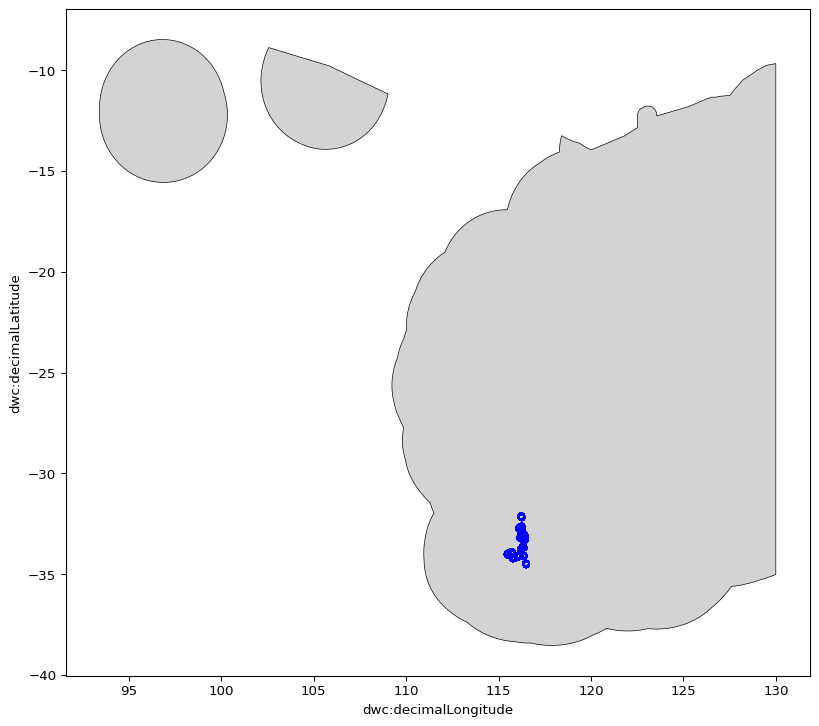

In [24]:
# visualize the coordinates.
basemap: gpd.GeoDataFrame = gpd.read_file(EEZ)
f, ax = plt.subplots(1, figsize=(10,10), dpi=96)
basemap.plot(ax=ax, color='lightgray')
extents.plot(ax=ax,cmap=None, alpha=1, edgecolor='black', color='none', linewidths=0.5)
ef.loc[lat_type_valid & lon_type_valid & loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude', y='dwc:decimalLatitude', edgecolor='blue', color='none')
#ef.loc[lat_type_valid & lon_type_valid  & ~loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude',y='dwc:decimalLatitude', edgecolor='red', color='none')
plt.show()

The Visualization of this function:

ef.loc[lat_type_valid & lon_type_valid & loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude', y='dwc:decimalLatitude', edgecolor='blue', color='none')

shows that all latitude and longitude falls within the location domain.

While this function below is checking if the lat and long falls outside or are not in the loc_domain (~loc_domain)

ef.loc[lat_type_valid & lon_type_valid  & ~loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude',y='dwc:decimalLatitude', edgecolor='red', color='none')

The visualization result shows empty lat and long, which means no latitude and longitude is found outside the loc_domain

Step 9) Populate errors(bio) and status(bio):
- status(bio) is either 'valid'/'invalid' 
- errors(bio) gives reason(s) for invalidation.

In [27]:
gf: pd.DataFrame = ef.copy(deep=True)
gf['errors(bio)'] = [[] for x in range(len(gf))]
gf['status(bio)'] = float('nan')

invalid_dtype: dict[str, pd.Series] = {
    'dwc:decimalLongitude': ~lon_type_valid, # not in lon_type_valid
    'dwc:decimalLatitude': ~lat_type_valid,
    'dwc:eventDate': ~date_type_valid,
    'dwc:taxonName': ~sci_type_valid}

for column, series in invalid_dtype.items():    
    gf.loc[series, 'status(bio)'] = 'INVALID'
    message: str = f'invalid dtype in column: {column}'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

invalid_domain: dict[str, pd.Series] = {
    'location': ~loc_domain & lon_type_valid & lat_type_valid,
    'datetime': ~date_domain & date_type_valid
    }

for domain, series in invalid_domain.items():
    message: str = f'observation outside valid {domain} domain'
    gf.loc[series, 'status(bio)'] = 'INVALID'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

message: str = f'Record contains character with umlat.'
gf.loc[umlat, 'status(bio)'] = 'INVALID'
gf.loc[umlat, 'errors(bio)'].apply(lambda x: x.append(message))

# Set status to valid on  empty 'status(bio)' column data
m: pd.Series = gf['status(bio)'].isna()
gf.loc[m, 'status(bio)'] = 'VALID'
meta: list[str] = ['status(bio)','errors(bio)']

gf = gf.loc[:, meta+dwc+verbatim+unmapped]
gf.head()

0                                                                status(bio)  \
dwc:datasetName            submission_id(bio) persistent_id(bio)               
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab         VALID   
                                              2024JZIDF2f95213         VALID   
                                              2024JZIDF2f98208         VALID   
                                              2024JZIDF2f980d2         VALID   
                                              2024JZIDF2f97e33         VALID   

0                                                                errors(bio)  \
dwc:datasetName            submission_id(bio) persistent_id(bio)               
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab            []   
                                              2024JZIDF2f95213            []   
                                              2024JZIDF2f98208            []   
                                              2024JZIDF2f980d2            []   
                                              2024JZIDF2f97e33            []   

0                                                                 dwc:decimalLatitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                        
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab             -33.281140   
                                              2024JZIDF2f95213             -33.267320   
                                              2024JZIDF2f98208             -33.904170   
                                              2024JZIDF2f980d2             -34.022660   
                                              2024JZIDF2f97e33             -33.919728   

0                                                                 dwc:decimalLongitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              116.430840   
                                              2024JZIDF2f95213              116.423640   
                                              2024JZIDF2f98208              115.694000   
                                              2024JZIDF2f980d2              115.496550   
                                              2024JZIDF2f97e33              115.664395   

0                                                                dwc:eventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                 
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab      2010-11-01   
                                              2024JZIDF2f95213      2004-10-05   
                                              2024JZIDF2f98208      2006-09-12   
                                              2024JZIDF2f980d2      2005-11-16   
                                              2024JZIDF2f97e33      2005-09-15   

0                                                                                               dwc:taxonName  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                                                
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab                             Acarospora citrina   
                                              2024JZIDF2f95213    Acarospora sp. brown (R.J. Cranfield 20633)   
                                              2024JZIDF2f98208                             Amandinea punctata   
                                              2024JZIDF2f980d2                             Amandinea punctata   
                                              2024JZIDF2f97e33                             Amandinea punctata   

0                                                                dwc:verbatimEventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              

Step 10) Log summary of validation results.

In [28]:
# count invalid records.
invalid: pd.Series = (gf['status(bio)'] == 'INVALID')
invalid_count: int = len(gf.loc[invalid])

# list all reasons for invalidation, with counts.
ag: pd.DataFrame = gf.loc[invalid].copy(deep=True)
ag['errors(bio)'] = ag['errors(bio)'].apply(lambda x: str(sorted(x)))
ag: pd.DataFrame = ag.groupby(by='errors(bio)', as_index=False)['status(bio)'].count()
assert ag['status(bio)'].sum() == invalid_count

reasons: str = ag.to_string(header=False, index=False)
entry: str = f'{invalid_count} out of {len(gf)} records marked as invalid, reasons: {reasons}.'
logevent(description=entry, user=socket.gethostname(), eventlog=eventlog)

,event_id,datetime,user,description
0,2024JZIBF47f7895,2024-09-25T08:01:05.294792,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" : N/A"
1,2024JZIDF289f78f,2024-09-25T08:03:05.166427,Charles,"""AquaticProjects/ForestCheck Data/Cryptogams/Cryptogams Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}"
2,2024JZIDF34e37af,2024-09-25T08:03:05.216644,Charles,"7499 uids added to column ""persistent_id(bio)""."
3,2024JZIDG2c8efa2,2024-09-25T08:03:06.182530,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."
4,2024JZIDG316c77c,2024-09-25T08:03:06.202457,Charles,"columns remapped: {'TAXON NAME': 'dwc:taxonName', 'DATE': 'dwc:eventDate', 'Latitude': 'dwc:decimalLatitude', 'Longitude': 'dwc:decimalLongitude'}"
5,2024JZIDG31f9b22,2024-09-25T08:03:06.204714,Charles,"verbatim fields added: {'TAXON NAME': 'dwc:verbatimIdentification', 'DATE': 'dwc:verbatimEventDate', 'Latitude': 'dwc:verbatimLatitude', 'Longitude': 'dwc:verbatimLongitude'}"
6,2024JZITJc210854,2024-09-25T08:19:09.794907,Charles,number of missing string values replaced: 0.
7,2024JZJUC2bc2d00,2024-09-25T09:20:02.179267,Charles,"95 out of 7499 records marked as invalid, reasons: ['Record contains character with umlat.'] 94\n['invalid dtype in column: dwc:taxonName'] 1."


Step 11) write to 025-preprocessed-data.

In [29]:
write_to_blob(gf, a25_preprocessed, targetp, index=True, timeout=12000)
tagfile(a25_preprocessed, targetp, tags)

{'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}

Step 12) write log to 030-ingestion-ready

In [30]:
# write log to blob.
write_to_blob(eventlog, a30_ingestion, logpath, index=False, timeout=12000)
tagfile(a30_ingestion, logpath, tags)

{'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}

Step 13) Separate valid/invalid records.

In [31]:
# isolate invalid records, write to predefined location.
v: pd.Series = (gf['status(bio)'] == 'VALID')
inval: pd.DataFrame = gf.loc[~v]
valid: pd.DataFrame = gf.loc[v]


Step 14a) Write invalid records to 030-ingestion-ready

In [33]:
write_to_blob(inval, a30_ingestion, invpath, index=True, timeout=12000)
tagfile(a30_ingestion, invpath, tags)

{'submission_id': '2024JZIDF111caee', 'dataset': 'Crptogams Master File data'}

Step 14b) No Partition to be done, since the total record is below 10,000. A file extension will be created for the Valid records 

In [34]:
hf: pd.DataFrame = valid.copy(deep=True)
PARTCOLUMNS: list[str] = []

if len(hf) > 0:  # Checking that hf dataframe isn't empty
    if len(PARTCOLUMNS) > 0:  # If PARTCOLUMNS isn't empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_{combine_str(x[PARTCOLUMNS]).lower()}_', axis=1)
    else:  # if it's empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_', axis=1)
    hf.sort_values(by='filename(bio)', inplace=True)
    
    # Generate the filename by appending .csv extension
    hf['filename(bio)'] = hf.apply(lambda x: f"{x['filename(bio)']}.csv", axis=1) 

hf.head()

0                                                                status(bio)  \
dwc:datasetName            submission_id(bio) persistent_id(bio)               
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab         VALID   
                                              2024JZIDF3300395         VALID   
                                              2024JZIDF32fffd7         VALID   
                                              2024JZIDF3301609         VALID   
                                              2024JZIDF32ffe50         VALID   

0                                                                errors(bio)  \
dwc:datasetName            submission_id(bio) persistent_id(bio)               
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab            []   
                                              2024JZIDF3300395            []   
                                              2024JZIDF32fffd7            []   
                                              2024JZIDF3301609            []   
                                              2024JZIDF32ffe50            []   

0                                                                 dwc:decimalLatitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                        
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab             -33.281140   
                                              2024JZIDF3300395             -33.204150   
                                              2024JZIDF32fffd7             -34.089222   
                                              2024JZIDF3301609             -33.765797   
                                              2024JZIDF32ffe50             -34.089222   

0                                                                 dwc:decimalLongitude  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              116.430840   
                                              2024JZIDF3300395              116.389050   
                                              2024JZIDF32fffd7              116.368096   
                                              2024JZIDF3301609              116.199960   
                                              2024JZIDF32ffe50              116.368096   

0                                                                dwc:eventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                 
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab      2010-11-01   
                                              2024JZIDF3300395      2010-11-02   
                                              2024JZIDF32fffd7      2009-08-13   
                                              2024JZIDF3301609      2014-09-06   
                                              2024JZIDF32ffe50      2009-08-13   

0                                                                              dwc:taxonName  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                               
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab            Acarospora citrina   
                                              2024JZIDF3300395    Ochrolechia subrhodotropa    
                                              2024JZIDF32fffd7    Ochrolechia subrhodotropa    
                                              2024JZIDF3301609    Ochrolechia subrhodotropa    
                                              2024JZIDF32ffe50    Ochrolechia subrhodotropa    

0                                                                dwc:verbatimEventDate  \
dwc:datasetName            submission_id(bio) persistent_id(bio)                         
Crptogams Master File data 2024JZIDF111caee   2024JZIDF2f944ab              2010-11-01   
                                              2024JZIDF3300395              2010-11-02   
               

Step 15) Write csv file to 030-ingestion-ready

In [35]:
jf: pd.DataFrame = hf.copy(deep=True)
if (len(jf) > 0): # Checking that jf dataframe isn't empty
    for mypath in jf['filename(bio)'].unique():
        m: pd.Series = (jf['filename(bio)'] == mypath)
        segment: pd.DataFrame = jf.loc[m].drop(columns='filename(bio)')
        write_to_blob(segment, a30_ingestion, Path(mypath), index=True, timeout=12000)
        tagfile(a30_ingestion, Path(mypath), tags)